# **Implementation**

## **Importing libraries**

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
!(pip install lime)
import lime
import lime.lime_tabular
!(pip install shap)
import shap
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=571e28c460e63c50807bb3eee4fa4610b3b51dbf270c5489dab5cae18c991cae
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 4.2 MB/s eta 0:00:00


## **Reading dataset**

In [2]:
# Reading dataset
data = pd.read_csv('CnegvsCpos.csv')

## **Data Preprocessing**

In [3]:
# Preprocessing
data = data.drop(columns=['race_White','race_AA','race_Other',
                          'ethnicity_Hispanic_YN','patient_class',
                          'encounter_type','reason_for_visit', 'SBP',
                          'DBP','Month'])
data["BMI"].fillna(data["BMI"].mean(), inplace=True)
data["BSA"].fillna(data["BSA"].mean(), inplace=True)
data.drop_duplicates(inplace=True)
data.drop([40003, 40004], axis=0, inplace=True)

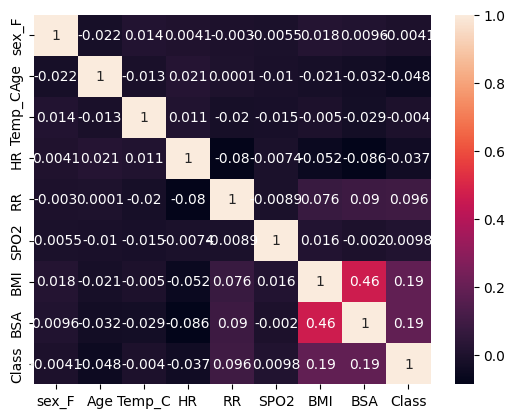

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
corrMatrix = data.corr()
sns.heatmap(corrMatrix, annot=True )
plt.savefig('Correlation.pdf', bbox_inches='tight')
plt.show()

In [6]:
# Split data
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [7]:
import numpy as np

# Before resampling
print("Before resampling:")
print(np.bincount(y))

# Apply SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='minority')
X_resampled, y_resampled = sm.fit_resample(X, y)

# After resampling
print("After resampling:")
print(np.bincount(y_resampled))


Before resampling:
[36100 13898]
After resampling:
[36100 36100]


## **Implemenataion of Stack model & Accuracy Calculation**

In [10]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Assuming you have X_train, X_test, y_train, and y_test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=0)

# Train base models
# Logistic Regression model
logreg = LogisticRegressionCV(cv=5, scoring='accuracy', max_iter=500, random_state=42)
logreg.fit(X_train, y_train)

# RandomForestRegressor model
rf = RandomForestRegressor(n_estimators=1000, max_depth=20, random_state=42, min_samples_split=5, min_samples_leaf=2)
rf.fit(X_train, y_train)

# XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=500, learning_rate=0.01, max_depth=10, subsample=0.8, colsample_bytree=0.8, gamma=0.5, random_state=42)
xgb.fit(X_train, y_train)

# Make predictions (probabilities instead of hard predictions)
logreg_pred_probs = logreg.predict_proba(X_test)[:, 1]
rf_pred_probs = rf.predict(X_test)
xgb_pred_probs = xgb.predict_proba(X_test)[:, 1]

# Meta model
blender = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=42)
blender.fit(np.column_stack([logreg_pred_probs, rf_pred_probs, xgb_pred_probs]), y_test)

# Predictions
stack_pred_probs = blender.predict_proba(np.column_stack([logreg_pred_probs, rf_pred_probs, xgb_pred_probs]))[:, 1]
stack_pred = np.round(stack_pred_probs).astype(int)  # Use np.round to get binary predictions

# Evaluate stacked model
accuracy = accuracy_score(y_test, stack_pred)
f1 = f1_score(y_test, stack_pred)
precision = precision_score(y_test, stack_pred)
recall = recall_score(y_test, stack_pred)

# Display evaluation metrics
print("Stacked Model Evaluation:")
print("Accuracy: ", accuracy)
print("F1 Score: ", f1)
print("Precision: ", precision)
print("Recall: ", recall)


Stacked Model Evaluation:
Accuracy:  0.8656509695290858
F1 Score:  0.8633032694475761
Precision:  0.8837276399307559
Recall:  0.843801652892562


## **ELI5 - Explanable Ai**

In [12]:
!(pip install eli5)

# Import ELI5
import eli5

# Interpret Meta model (RandomForestClassifier)
print("Meta Model (RandomForestClassifier) Interpretation:")
eli5.show_prediction(blender, np.column_stack([logreg_pred_probs, rf_pred_probs, xgb_pred_probs])[27],
                     feature_names=['logreg', 'rf', 'xgb'], show_feature_values=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107717 sha256=f210a7d42ee94fb0654cb79b6b90ac6160ab2f39544f27f5f7fd4df83f31964d
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5
Meta Model (RandomForestClassifier) Interpretation:


## **LIME - Explainable AI**

In [13]:
# Import necessary libraries
import lime
from lime.lime_tabular import LimeTabularExplainer

# Create a LimeTabularExplainer
explainer = LimeTabularExplainer(training_data=np.column_stack([logreg_pred_probs, rf_pred_probs, xgb_pred_probs]),
                                 feature_names=['logreg', 'rf', 'xgb'],
                                 mode='classification')

# Explain instance using LIME
exp = explainer.explain_instance(data_row=np.column_stack([logreg_pred_probs, rf_pred_probs, xgb_pred_probs])[27],
                                 predict_fn=blender.predict_proba)
exp.show_in_notebook(show_table=True)


In [14]:
# Import necessary libraries
import lime
from lime.lime_tabular import LimeTabularExplainer

# Create a LimeTabularExplainer
explainer = LimeTabularExplainer(training_data=X_train.values,  # Use your original training data
                                 feature_names=X_train.columns,  # Use the column names from your original data
                                 mode='classification')

# Explain instance using LIME
exp = explainer.explain_instance(data_row=X_test.values[27],  # Use a row from your original test data
                                 predict_fn=xgb.predict_proba)  # Use the predict_proba method of the XGBoost model
exp.show_in_notebook(show_table=True)


## **DEEP ShAp - Explainable AI**

[18:54:57] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


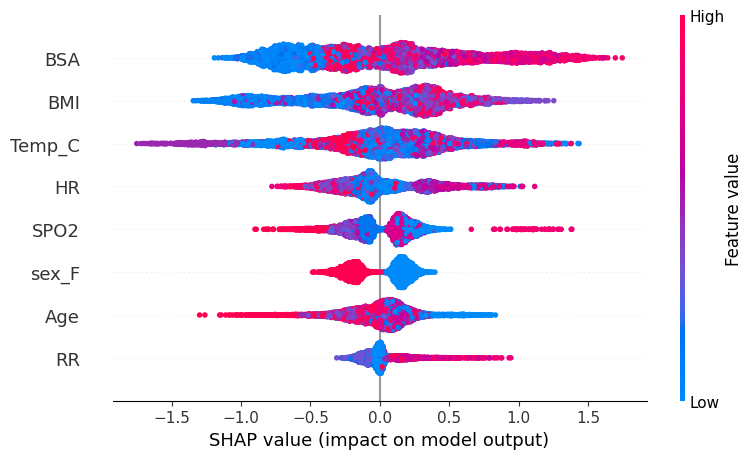

In [15]:
# Import necessary libraries
import shap

# Create a TreeExplainer for the XGBoost model
shap_explainer = shap.TreeExplainer(xgb)  # Use the XGBoost model

# Calculate SHAP values
shap_values = shap_explainer.shap_values(X_test)  # Use your original test data

# Plot force plot for a test instance
test_instance = X_test.iloc[27]  # Use a row from your original test data
shap.force_plot(shap_explainer.expected_value, shap_values[27,:], test_instance)

# Plot summary plot
shap.summary_plot(shap_values, X_test)  # Use your original test data



## **ROC Curve - Analysis**

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


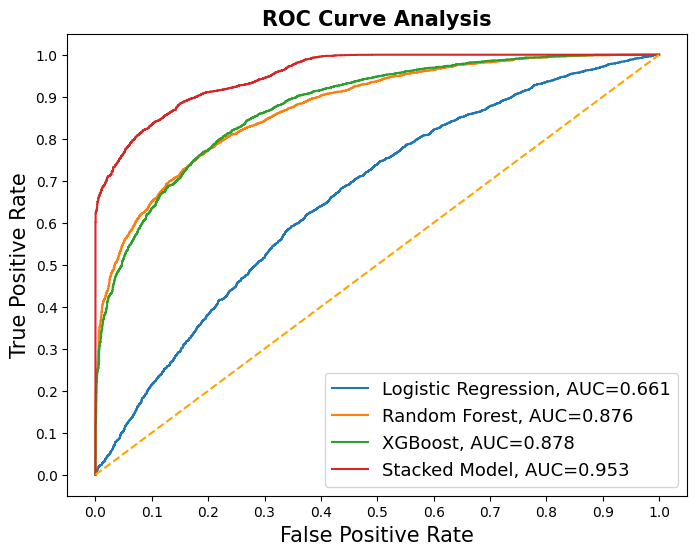

In [16]:
# Import necessary libraries
from sklearn.metrics import roc_curve, auc

# Define a result_table to store the fpr, tpr, and auc
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Calculate the ROC curve and AUC for each model
for cls, pred_probs in zip(['Logistic Regression', 'Random Forest', 'XGBoost', 'Stacked Model'],
                           [logreg_pred_probs, rf_pred_probs, xgb_pred_probs, stack_pred_probs]):
    fpr, tpr, _ = roc_curve(y_test, pred_probs)
    auc_score = auc(fpr, tpr)
    result_table = result_table.append({'classifiers': cls,
                                        'fpr': fpr,
                                        'tpr': tpr,
                                        'auc': auc_score}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

# Plot the ROC curve
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'],
             result_table.loc[i]['tpr'],
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.savefig('ROC.pdf', bbox_inches='tight')
plt.show()
